In [3]:
# TODO: remove this section after debug
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# TODO: 1. the test_images csv file has to include only the image name without path. upon loading the dataset it has to concatenate the path.
#       2. The external repository to include source images, without normalization, which is done here.
#       3. for some organelles: [Propper(('+', Padder('+', 32, 'constant', 0, None)))].
#       4. add explanations

In [16]:
from predict import predict
from datetime import datetime
import json
import os
import pandas as pd
import numpy as np
import tifffile
from utils.functions import show_images_subplots

# Presets
# TODO: replace with real repository path
large_files_repository_path = f'/sise/assafzar-group/assafzar/Nitsan/external_repository_for_large_files_temp'
organelle = 'microtubules' 

def initialize_experiment(organelle, large_files_repository_path):
    formatted_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    path_save_dir = f'./experiments/{organelle}/{formatted_time}'
    with open(f'{large_files_repository_path}/{organelle}/models/context_model_config.json', 'r') as file:
        context_model_config = json.load(file)
    return path_save_dir, context_model_config

def plot_examples(path_save_dir):
    entries = [f'{path_save_dir}/{entry}' for entry in os.listdir(path_save_dir)]
    dirs = [entry for entry in entries if os.path.isdir(entry)]
    images = []
    titles = []
    for dir in dirs:
        index = int(os.path.basename(dir))
        signal = tifffile.imread(f'{dir}/signal.tiff')
        target = tifffile.imread(f'{dir}/target.tiff')
        mask = tifffile.imread(f'{dir}/mask.tiff')
        prediction = np.squeeze(tifffile.imread(f'{dir}/prediction.tiff')) * mask
        z = signal.shape[0]//2
        images.extend([signal[z], target[z], prediction[z]])
        titles.extend([f'Signal ({index})', 'Target', 'Prediction'])
    show_images_subplots(shape=(len(dirs),3), images=images, titles=titles, axis_off=True, figsize=(15,8))

## Without context

In [40]:
# initialize the experiment
path_save_dir, context_model_config = initialize_experiment(organelle, large_files_repository_path)

# prepare transforms, embed patch size
train_patch_size = context_model_config['train_patch_size']
transforms = context_model_config['transforms']
transforms = {k:v.replace('train_patch_size', train_patch_size) for k,v in transforms.items()}
transforms

# prepare args and run prediction
args={
    'path_images_csv': f'../data/{organelle}/test_images.csv',
    'masked': True,
    'transforms': transforms,
    'path_model': f'{large_files_repository_path}/{organelle}/models/best_model_no_context.p',
    'path_context_csv': '',
    'context_features': [],
    'daft_embedding_factor': None,
    'daft_scale_activation': None,
    'path_save_dir': path_save_dir,
    'save_only_prediction': False,
    'selected_indices': [44, 45], # interphase, mitosis
    'evaluation_metrics': ['mse', 'pearsonr']
}

predict.run_prediction(**args)

  0%|          | 0/2 [00:00<?, ?it/s]/sise/home/elmalni/Research/CELTIC/celtic_net/fnet_model.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal = torch.tensor(signal, dtype=torch.float32, device=self.device)
100%|██████████| 2/2 [00:35<00:00, 17.98s/it]


In [41]:
results = pd.read_csv(f'{path_save_dir}/evaluation.csv')
print(f'Mean PCC = {np.mean(results.pearsonr.values):.3f}')
results

Mean PCC = 0.630


,cell_index,mse,pearsonr
0,44,0.266257,0.856797
1,45,0.838720,0.402408


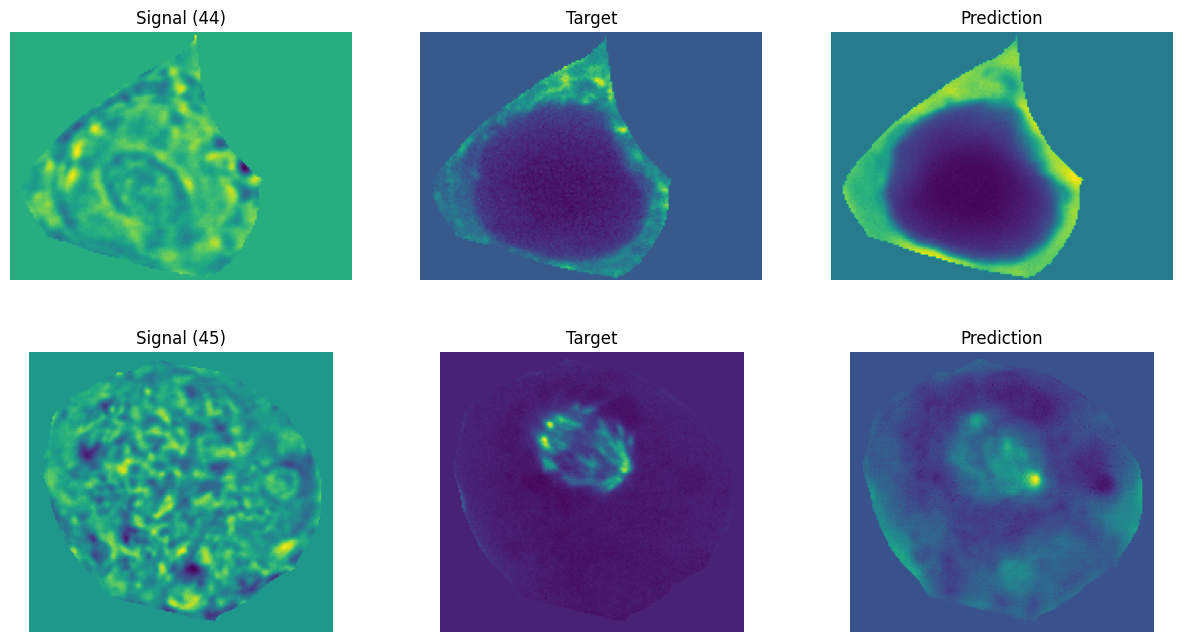

In [43]:
plot_examples(path_save_dir)

## With context

In [46]:
# initialize another experiment
path_save_dir, context_model_config = initialize_experiment(organelle, large_files_repository_path)

# prepare args and run prediction
args={
    'path_images_csv': f'../data/{organelle}/test_images.csv',
    'masked': True,
    'transforms': transforms,
    'path_model': f'{large_files_repository_path}/{organelle}/models/best_model_context.p',
    'path_context_csv': f'../data/{organelle}/test_context.csv',
    'context_features': context_model_config['context_features'],
    'daft_embedding_factor': context_model_config['daft_embedding_factor'],
    'daft_scale_activation': context_model_config['daft_scale_activation'],
    'path_save_dir': path_save_dir,
    'save_only_prediction': False,
    'selected_indices': [44, 45], # interphase, mitosis
    'evaluation_metrics': ['mse', 'pearsonr']
}

predict.run_prediction(**args)

bottleneck_dim=132
embedding factor: 4 | activation: Sigmoid()


 50%|█████     | 1/2 [00:12<00:12, 12.38s/it]

In [47]:
results = pd.read_csv(f'{path_save_dir}/evaluation.csv')
print(f'Mean PCC = {np.mean(results.pearsonr.values):.3f}')
results

Mean PCC = 0.777


,cell_index,mse,pearsonr
0,44,0.330851,0.832457
1,45,0.536928,0.722345


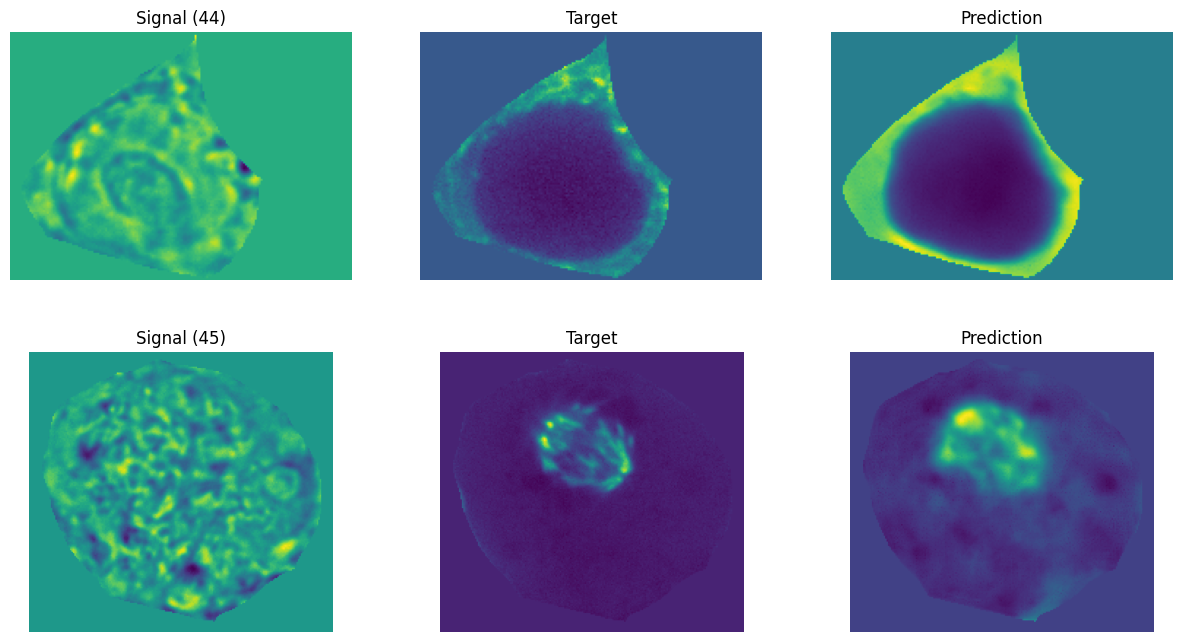

In [48]:
plot_examples(path_save_dir)